In [1]:
#import requred libraries
import random
import numpy as np
import os
import glob

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

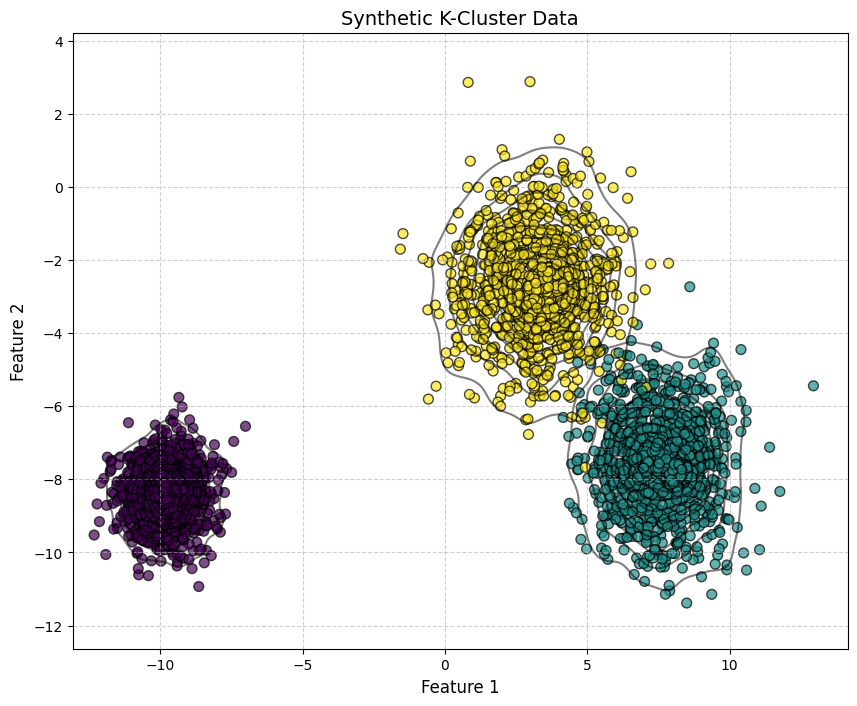

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters for synthetic data
n_samples = 3000  # Total number of data points
n_features = 2   # Number of features (dimensions)
n_clusters = k =3   # Number of clusters
n_std=[np.sqrt(random.uniform(i,i+1)) for i in range(n_clusters)]


# Generate synthetic data
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=n_std)

# Visualize the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolor='k', alpha=0.7)
for i in range(n_clusters):
    data = X[y == i]
    sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=10, linewidths=1.5, color='k', alpha=0.5)

plt.title("Synthetic K-Cluster Data", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [4]:
# Unsupervised data for GMM MLE Learning via EM algorithm
data = X  # Number of clusters
N = X.shape[0]

In [5]:
# E step

import numpy as np
from scipy.stats import multivariate_normal

## E-step: Calculate responsibilities
def e_step(X, k, mixing_dic, mean_dic, cov_dic):
    N = X.shape[0]  # Number of data points
    responsibilities = np.zeros((N, k))  

    for i in range(k):
        # Calculate the probability of X under the i-th Gaussian
        rv = multivariate_normal(mean=mean_dic[i], cov=cov_dic[i], allow_singular = True)
        responsibilities[:, i] = mixing_dic[i] * rv.pdf(X)

    # Normalize responsibilities across clusters for each data point
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)

    return responsibilities


In [6]:

# M-step: Update parameters
def m_step(X, responsibilities, k):
    N, d = X.shape  # Number of data points (N) and dimensions (d)
    
    # Initialize dictionaries for updated parameters
    mixing_dic = {}
    mean_dic = {}
    cov_dic = {}
    
    # Update parameters for each cluster
    for i in range(k):
        # Sum of responsibilities for cluster i
        N_k = responsibilities[:, i].sum()
        
        # Update mixing coefficient
        mixing_dic[i] = N_k / N
        
        # Update mean
        mean_dic[i] = (responsibilities[:, i][:, np.newaxis] * X).sum(axis=0) / N_k
        
        # Update covariance matrix
        diff = X - mean_dic[i]
        cov_dic[i] = (responsibilities[:, i][:, np.newaxis] * diff).T @ diff / N_k
    
    return mixing_dic, mean_dic, cov_dic



In [7]:

# Visualize current associations of data points with clusters and add sigma bands around means
def visualize_clusters(X, responsibilities, k, mean_dic, cov_dic, step):
    """
    Visualize clusters with their corresponding sigma bands (ellipsoids) around the means.
    
    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        The data points.
    responsibilities : array-like, shape (n_samples, k)
        The responsibilities for each cluster.
    k : int
        The number of clusters.
    mean_dic : dict
        Dictionary of cluster means.
    cov_dic : dict
        Dictionary of cluster covariance matrices.
    """
    # Assign each data point to the cluster with the highest responsibility
    cluster_assignments = np.argmax(responsibilities, axis=1)
    
    # Define a list of colors for the clusters
    cluster_colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'brown', 'pink', 'gray']  # Add more colors if needed
    
    plt.figure(figsize=(12, 10))
    
    for i in range(k):
        # Plot data points belonging to cluster i
        cluster_points = X[cluster_assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.6, color=cluster_colors[i % len(cluster_colors)+3])
        
        # Plot the current mean of the cluster
        plt.scatter(mean_dic[i][0], mean_dic[i][1], color=cluster_colors[i % len(cluster_colors)], 
                    marker='x', s=100, label=f"Mean {i}")
        
        # Add an ellipse (sigma band) for the cluster
        
    
        for n in range(1, 4):  # 1-sigma, 2-sigma, 3-sigma bands
            eigenvalues, eigenvectors = np.linalg.eigh(cov_dic[i])  # Eigen decomposition of the covariance matrix
            angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])  # Angle of the first eigenvector
            angle = np.degrees(angle)  # Convert to degrees
            width, height = n * np.sqrt(eigenvalues)  # Scale by 2-sigma, 4-sigma, 6-sigma for 1, 2, 3 bands
            ell = Ellipse(xy=mean_dic[i], width=width, height=height, angle=angle, 
                  edgecolor=cluster_colors[i % len(cluster_colors)], facecolor='none', linestyle='--', linewidth=1.5)
            plt.gca().add_patch(ell)
    plt.title(f'Step {step} : Current Cluster Associations')
    plt.xlim(min(X[:,0])-1,max(X[:,0])+1)
    plt.ylim(min(X[:,1])-1,max(X[:,1])+1)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    

In [8]:
def train_gmm(X, n_components=3, n_steps=10, plot_intermediate_steps_flag=True, tol=1e-4):
    """
    Train a Gaussian Mixture Model (GMM) using the EM algorithm with stopping criteria.
    
    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        The data.
    n_components : int
        The number of clusters.
    n_steps : int
        Maximum number of iterations to run.
    plot_intermediate_steps_flag : bool
        Whether to plot intermediate steps.
    tol : float
        Convergence tolerance for stopping criteria.
    """
    # Step 1: Initialize parameters
    mixing_dic = {}
    X_f1_min = min(X[:, 0]) + random.uniform(-1, 1)
    X_f1_max = max(X[:, 0]) + random.uniform(-1, 1)
    X_f2_min = min(X[:, 1]) + random.uniform(-1, 1)
    X_f2_max = max(X[:, 1]) + random.uniform(-1, 1)
    mean_dic = {}
    cov_dic = {}
    for i in range(n_components):
        mixing_dic[i] = 1 / X.shape[0]
        mean_dic[i] = [random.uniform(X_f1_min, X_f1_max), random.uniform(X_f2_min, X_f2_max)]
        
        mat = [[random.uniform(np.sqrt(abs(X_f1_max - X_f1_min)), -np.sqrt(abs(X_f1_max - X_f1_min))),
                random.uniform(np.sqrt(abs(X_f1_max - X_f2_min)), -np.sqrt(abs(X_f1_max - X_f2_min)))],
               [random.uniform(np.sqrt(abs(X_f2_max - X_f1_min)), -np.sqrt(abs(X_f2_max - X_f1_min))),
                random.uniform(np.sqrt(abs(X_f2_max - X_f2_min)), -np.sqrt(abs(X_f2_max - X_f2_min)))]]
        
        cov_dic[i] = mat @ np.transpose(mat)

    print("Initial Parameters:")
    print(f"Mixing Coefficients: {mixing_dic} \n")
    print(f"Means: {mean_dic} \n")
    print(f"Covariances: {cov_dic} \n")

    # Step 2: Iterate between E-step and M-step
    plt.figure(figsize=(10, 8)) # Create a single figure for dynamic updates
    prev_log_likelihood = None  # Initialize previous log-likelihood
    for step in range(n_steps):
        print(f"\nStep {step + 1}")

        # E-step: Calculate responsibilities
        responsibilities = e_step(X, n_components, mixing_dic, mean_dic, cov_dic)

        # Visualize intermediate steps if flag is set
        if plot_intermediate_steps_flag:
              # Clear the current figure
            visualize_clusters(X, responsibilities, n_components, mean_dic, cov_dic, step)
            plt.savefig(f"Step_{str(step).zfill(2)}", dpi=300, bbox_inches='tight')
            plt.show()

        # M-step: Update parameters
        mixing_dic, mean_dic, cov_dic = m_step(X, responsibilities, n_components)

        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(np.sum([
            mixing_dic[i] * multivariate_normal(mean=mean_dic[i], cov=cov_dic[i], allow_singular= True).pdf(X)
            for i in range(n_components)
        ], axis=0)))
        print(f"Log-Likelihood: {log_likelihood}")

        # Check for convergence
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tol:
            print(f"Convergence reached at step {step + 1}.")
            break
        prev_log_likelihood = log_likelihood

        # Print updated parameters
        print(f"Mixing Coefficients: {mixing_dic} \n")
        print(f"Means: {mean_dic} \n")
        print(f"Covariances: {cov_dic}")

    # Final visualization
    if plot_intermediate_steps_flag:
        plt.clf()  # Clear the figure for the final visualization
        visualize_clusters(X, responsibilities, n_components, mean_dic, cov_dic, step)
        

    print("\nFinal Parameters:")
    print("Mixing Coefficients:", mixing_dic)
    print("Means:", mean_dic)
    print("Covariances:", cov_dic)
    plt.show()  # Ensure the final graph remains displayed
    return mixing_dic, mean_dic, cov_dic

In [9]:
# Define the pattern for the files to delete
file_pattern = "Step_*.png"

# Use glob to find all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through and delete each file
for file in files_to_delete:
    try:
        os.remove(file)  # Delete the file
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

Initial Parameters:
Mixing Coefficients: {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0.0003333333333333333} 

Means: {0: [np.float64(-0.5999355393454309), np.float64(-11.3581481702047)], 1: [np.float64(-2.155072302098043), np.float64(-5.3473007029998)], 2: [np.float64(-1.7031223198870542), np.float64(-0.6708390963726938)]} 

Covariances: {0: array([[13.94189919,  9.01320954],
       [ 9.01320954, 16.8133765 ]]), 1: array([[ 26.67499073, -16.96051953],
       [-16.96051953,  13.00218502]]), 2: array([[22.42437428, 15.61171801],
       [15.61171801, 12.33684884]])} 


Step 1


<Figure size 1000x800 with 0 Axes>

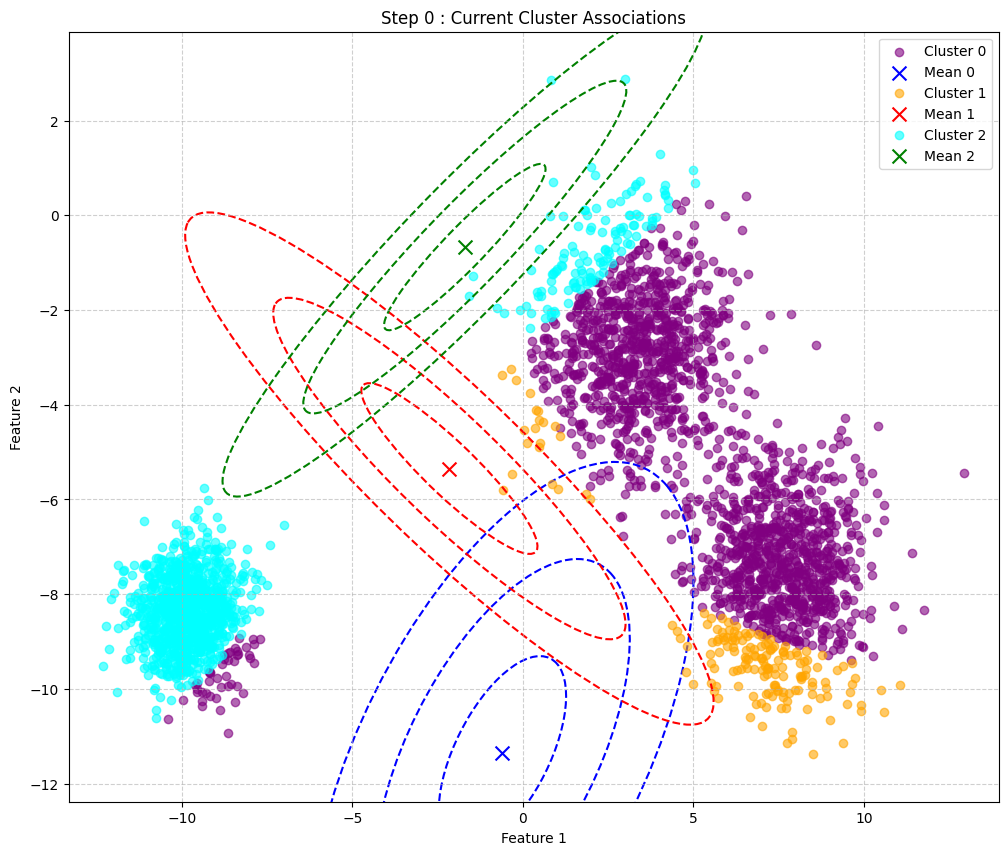

Log-Likelihood: -15191.974870364336
Mixing Coefficients: {0: np.float64(0.5655774108181132), 1: np.float64(0.08448929066860851), 2: np.float64(0.34993329851327826)} 

Means: {0: array([ 4.8809235 , -5.19692214]), 1: array([ 6.08128243, -7.96010745]), 2: array([-8.45789238, -7.43665442])} 

Covariances: {0: array([[14.68119812, -1.596346  ],
       [-1.596346  ,  6.63331357]]), 1: array([[ 6.95429652, -4.67825768],
       [-4.67825768,  4.38643783]]), 2: array([[15.66894113,  9.59056617],
       [ 9.59056617,  6.52974933]])}

Step 2


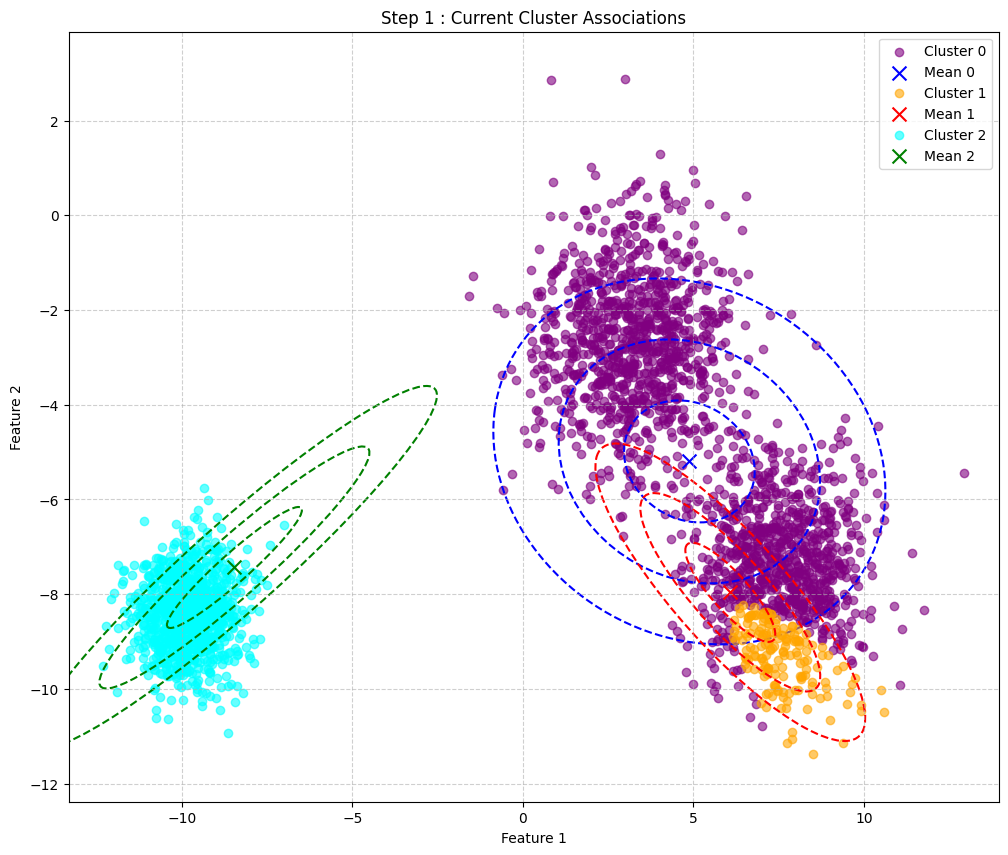

Log-Likelihood: -13736.840278387024
Mixing Coefficients: {0: np.float64(0.5578685765155963), 1: np.float64(0.09689197314805278), 2: np.float64(0.34523945033635095)} 

Means: {0: array([ 5.21140772, -4.69623927]), 1: array([ 6.79883299, -8.00758031]), 2: array([-9.41777601, -8.1635631 ])} 

Covariances: {0: array([[ 6.59006194, -4.89255288],
       [-4.89255288,  6.8717053 ]]), 1: array([[ 3.25338513, -2.18650397],
       [-2.18650397,  2.57329793]]), 2: array([[5.10703175, 2.77660774],
       [2.77660774, 2.26271873]])}

Step 3


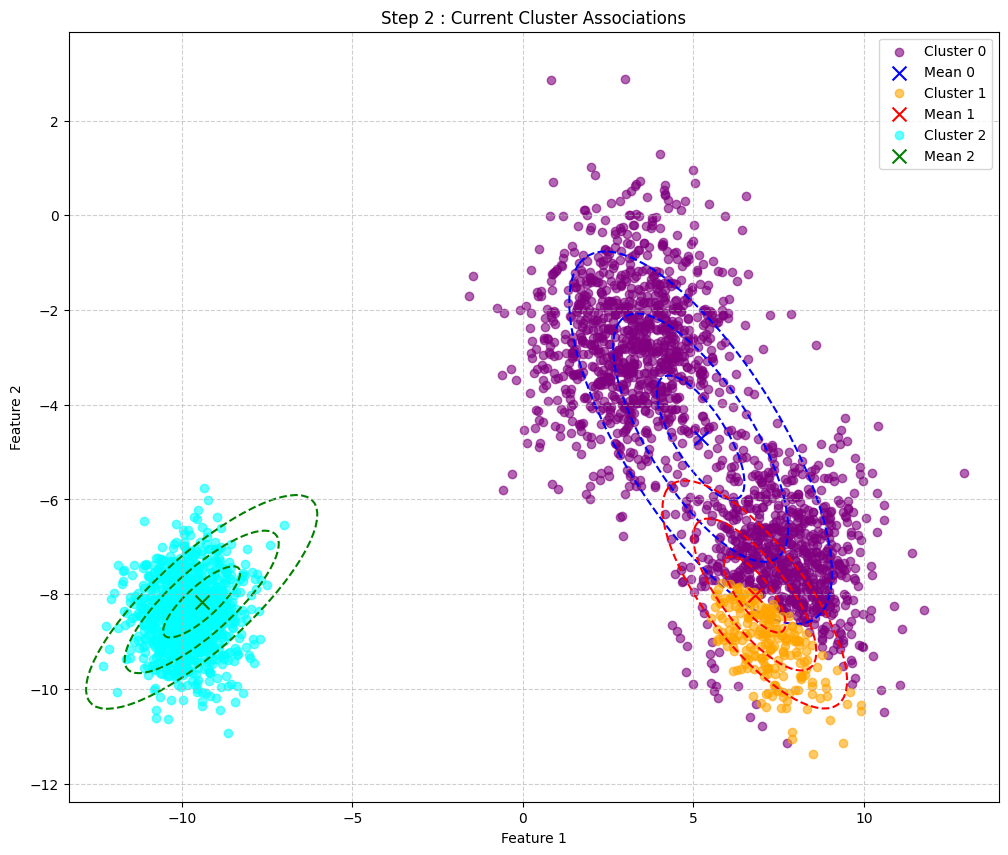

Log-Likelihood: -12937.95021851769
Mixing Coefficients: {0: np.float64(0.5648254462244257), 1: np.float64(0.10179543036583852), 2: np.float64(0.3333791234097358)} 

Means: {0: array([ 5.08284914, -4.57180604]), 1: array([ 7.03731116, -8.13985694]), 2: array([-9.81658204, -8.40864286])} 

Covariances: {0: array([[ 6.77955276, -5.03121346],
       [-5.03121346,  6.91563792]]), 1: array([[ 1.95210929, -0.99027933],
       [-0.99027933,  1.61289705]]), 2: array([[0.65231247, 0.03731996],
       [0.03731996, 0.58855163]])}

Step 4


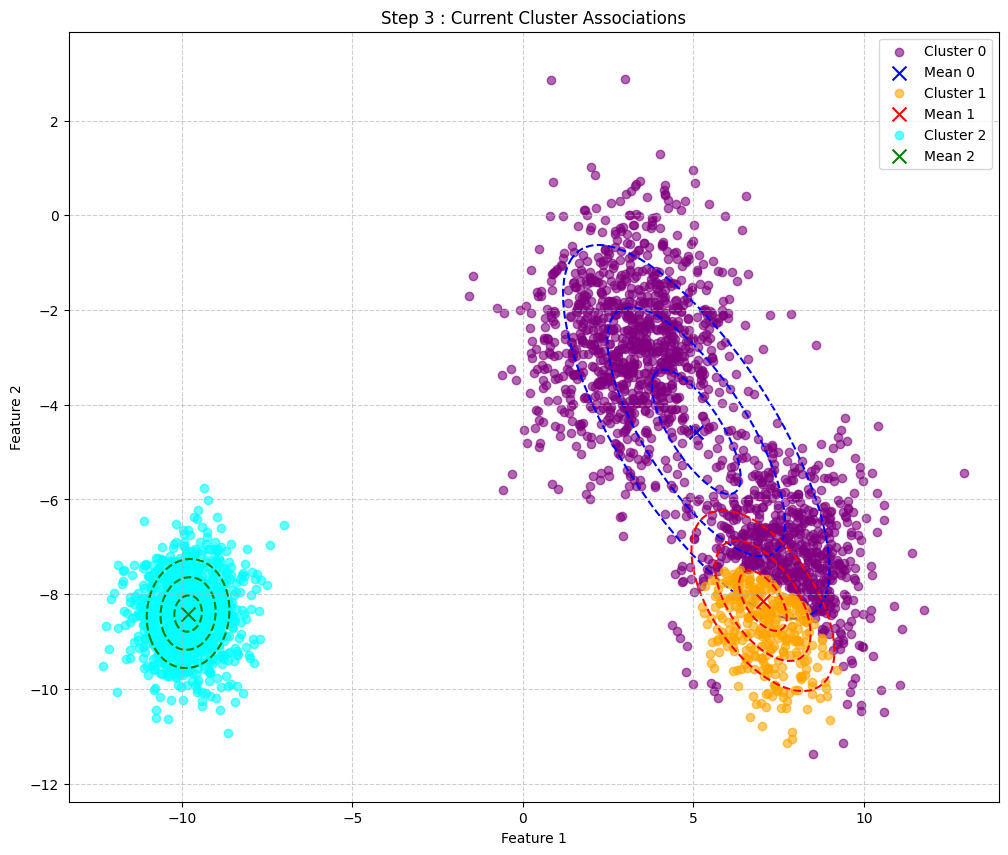

Log-Likelihood: -12869.527212705656
Mixing Coefficients: {0: np.float64(0.5499075994221725), 1: np.float64(0.11675906724454638), 2: np.float64(0.33333333333328113)} 

Means: {0: array([ 4.98465619, -4.45716816]), 1: array([ 7.24717969, -8.22205183]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 6.76355221, -4.88789353],
       [-4.88789353,  6.67905975]]), 1: array([[ 1.25568654, -0.31015876],
       [-0.31015876,  1.11829403]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 5


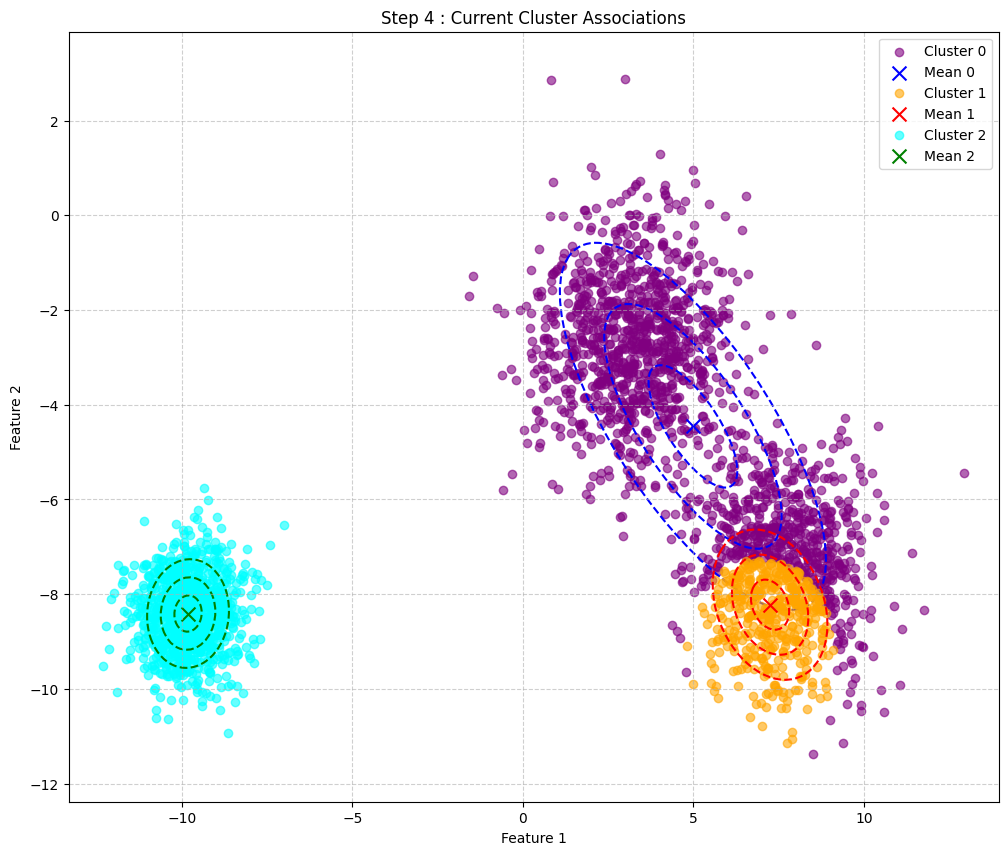

Log-Likelihood: -12825.365444487808
Mixing Coefficients: {0: np.float64(0.5276996765166945), 1: np.float64(0.13896699015008582), 2: np.float64(0.3333333333332198)} 

Means: {0: array([ 4.85730687, -4.30709541]), 1: array([ 7.36919604, -8.19026801]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 6.65720015, -4.66647472],
       [-4.66647472,  6.38607473]]), 1: array([[ 1.09307721, -0.06508788],
       [-0.06508788,  1.00712668]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 6


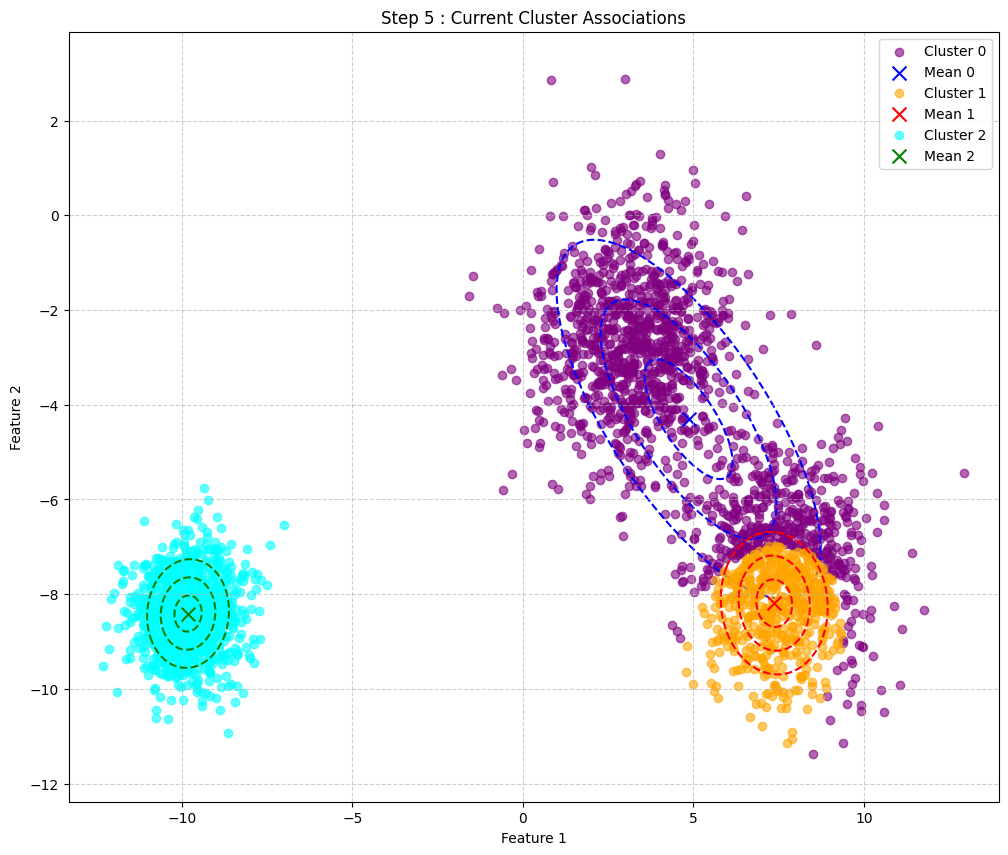

Log-Likelihood: -12792.705378424775
Mixing Coefficients: {0: np.float64(0.5050539983219936), 1: np.float64(0.16161266834486515), 2: np.float64(0.3333333333331412)} 

Means: {0: array([ 4.71369529, -4.1547994 ]), 1: array([ 7.46602117, -8.12208417]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 6.44655675, -4.38657841],
       [-4.38657841,  6.09448857]]), 1: array([[1.08664395, 0.04869241],
       [0.04869241, 1.01155994]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 7


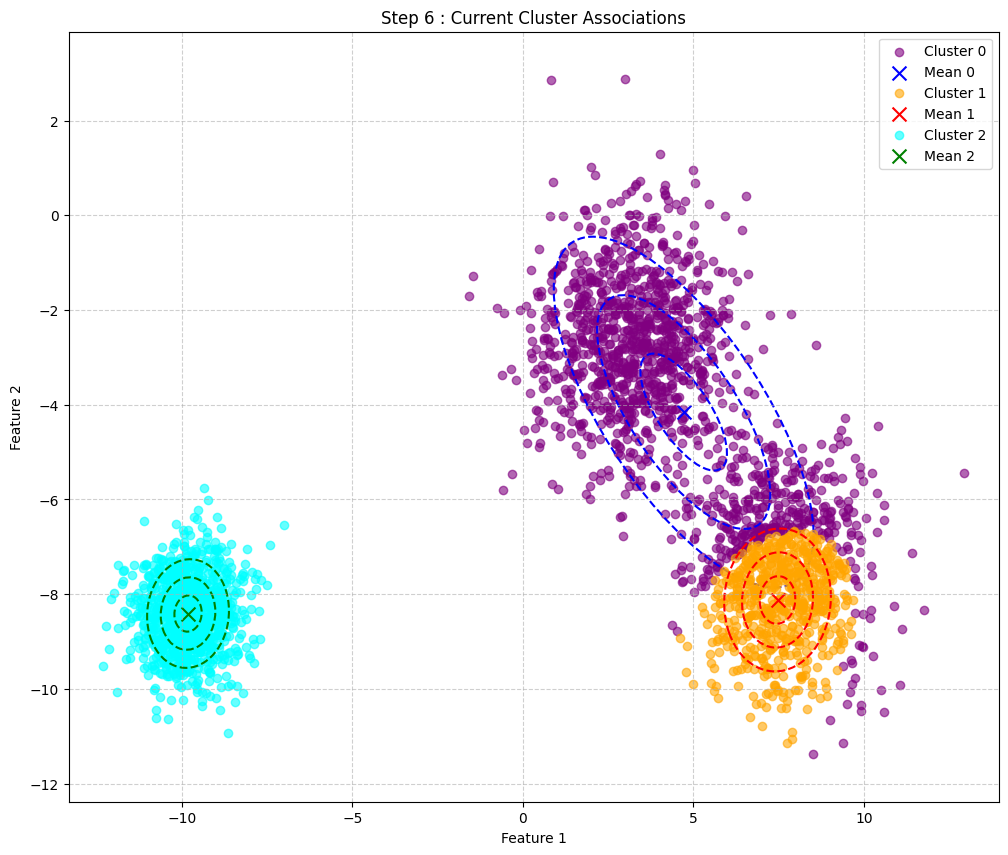

Log-Likelihood: -12765.677659193838
Mixing Coefficients: {0: np.float64(0.48373988456177563), 1: np.float64(0.18292678210520621), 2: np.float64(0.3333333333330182)} 

Means: {0: array([ 4.56211761, -4.00709494]), 1: array([ 7.54616683, -8.05042371]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 6.14255044, -4.05856681],
       [-4.05856681,  5.79894902]]), 1: array([[1.12408613, 0.11096997],
       [0.11096997, 1.05720899]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 8


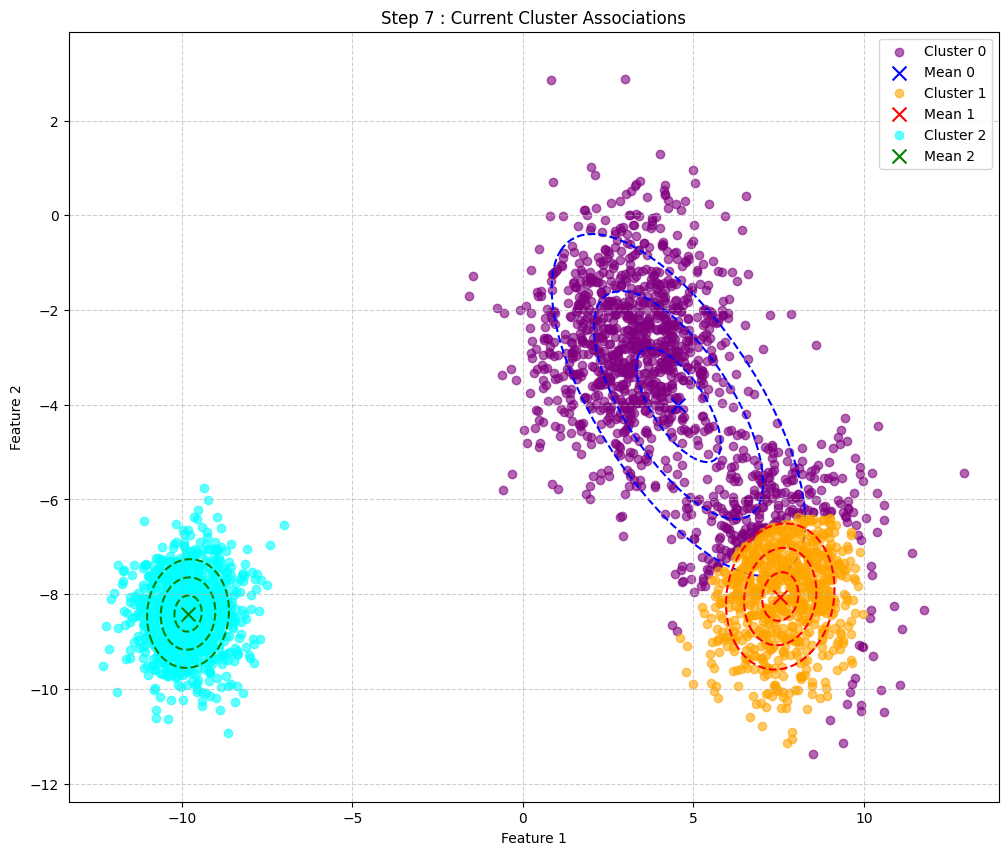

Log-Likelihood: -12741.700815363003
Mixing Coefficients: {0: np.float64(0.46400379865386066), 1: np.float64(0.20266286801327055), 2: np.float64(0.33333333333286885)} 

Means: {0: array([ 4.4081104, -3.8628598]), 1: array([ 7.60817362, -7.98690031]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 5.76884456, -3.69012367],
       [-3.69012367,  5.47902665]]), 1: array([[1.17304587, 0.1444208 ],
       [0.1444208 , 1.12139689]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 9


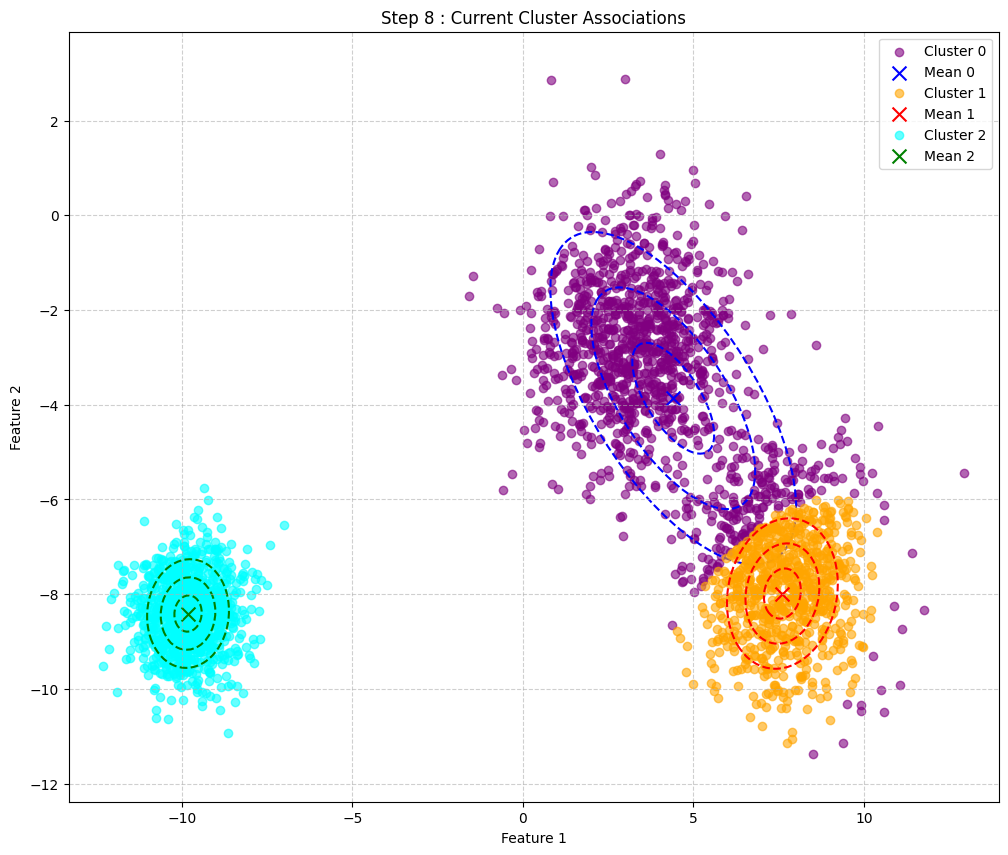

Log-Likelihood: -12718.194687573965
Mixing Coefficients: {0: np.float64(0.44553887498964223), 1: np.float64(0.22112779167761362), 2: np.float64(0.3333333333327442)} 

Means: {0: array([ 4.25312073, -3.71824103]), 1: array([ 7.65323807, -7.93391372]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 5.34100943, -3.27931639],
       [-3.27931639,  5.11326453]]), 1: array([[1.22487554, 0.15758041],
       [0.15758041, 1.19411754]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 10


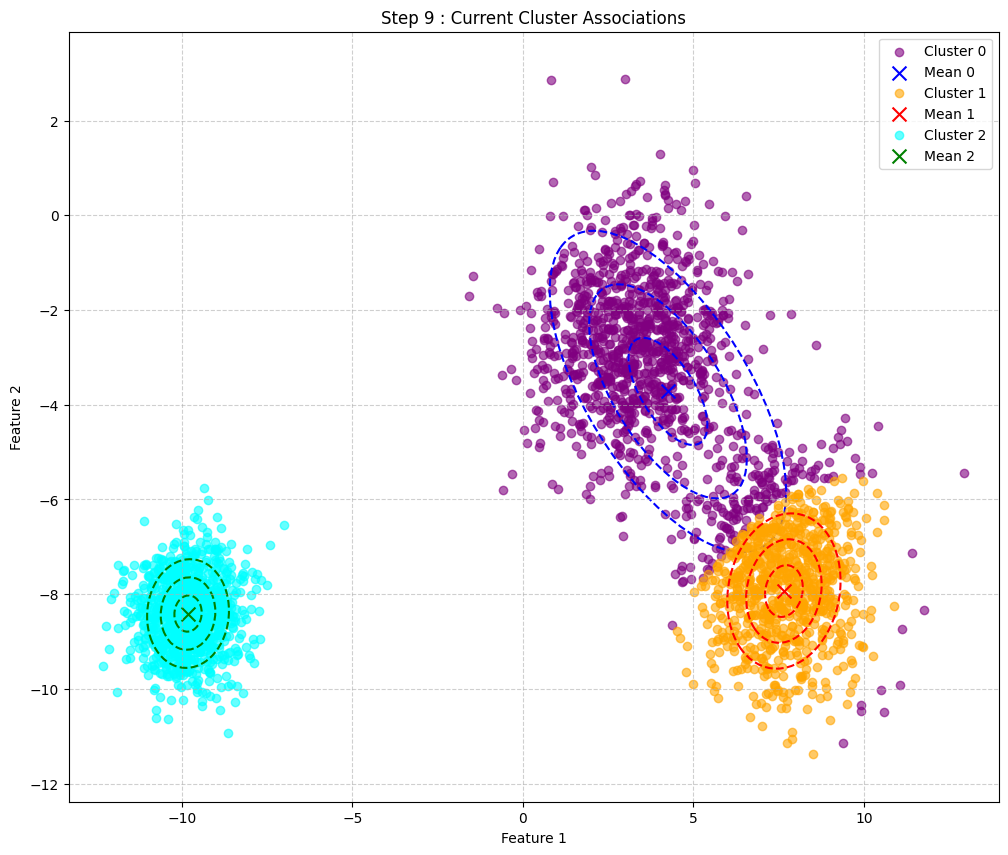

Log-Likelihood: -12691.782811751953
Mixing Coefficients: {0: np.float64(0.4277301201747291), 1: np.float64(0.2389365464925912), 2: np.float64(0.3333333333326797)} 

Means: {0: array([ 4.09429672, -3.5675985 ]), 1: array([ 7.68413311, -7.88937665]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 4.85735575, -2.81264537],
       [-2.81264537,  4.68035514]]), 1: array([[1.27960319, 0.15462185],
       [0.15462185, 1.26949376]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 11


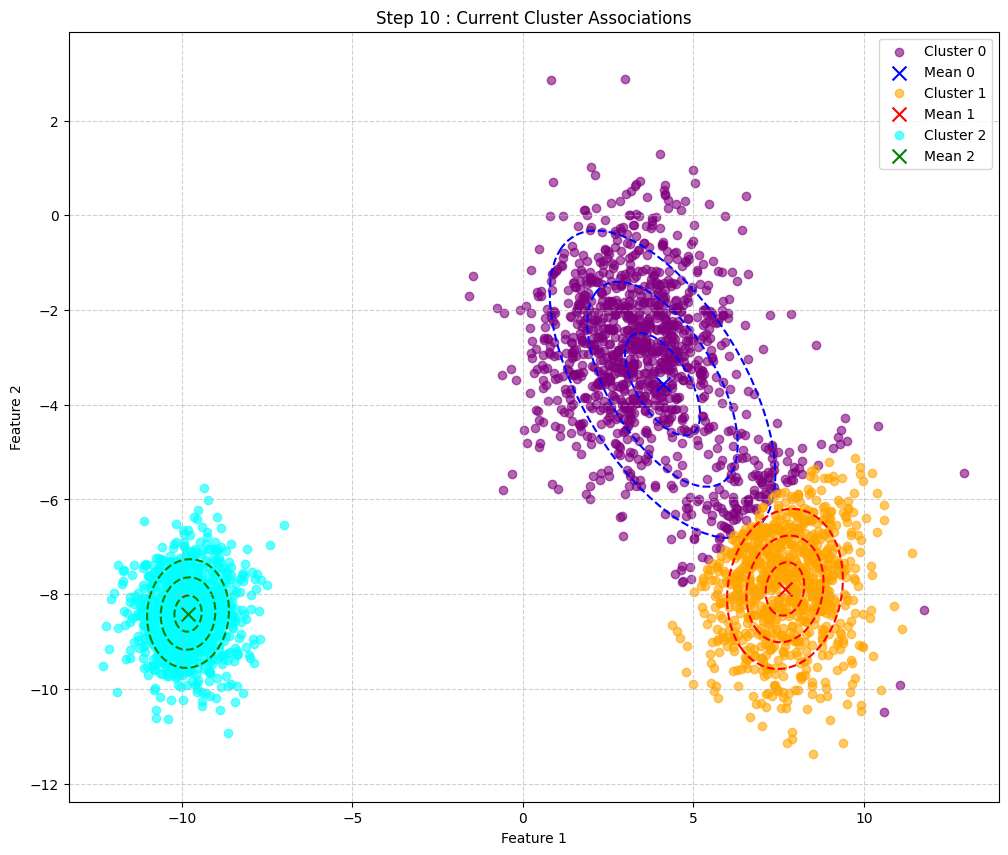

Log-Likelihood: -12658.156839076777
Mixing Coefficients: {0: np.float64(0.40990528537841925), 1: np.float64(0.25676138128890597), 2: np.float64(0.3333333333326748)} 

Means: {0: array([ 3.92668159, -3.40551421]), 1: array([ 7.7025085 , -7.84810965]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 4.30378791, -2.2741571 ],
       [-2.2741571 ,  4.16633955]]), 1: array([[1.33996534, 0.13989106],
       [0.13989106, 1.34328517]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 12


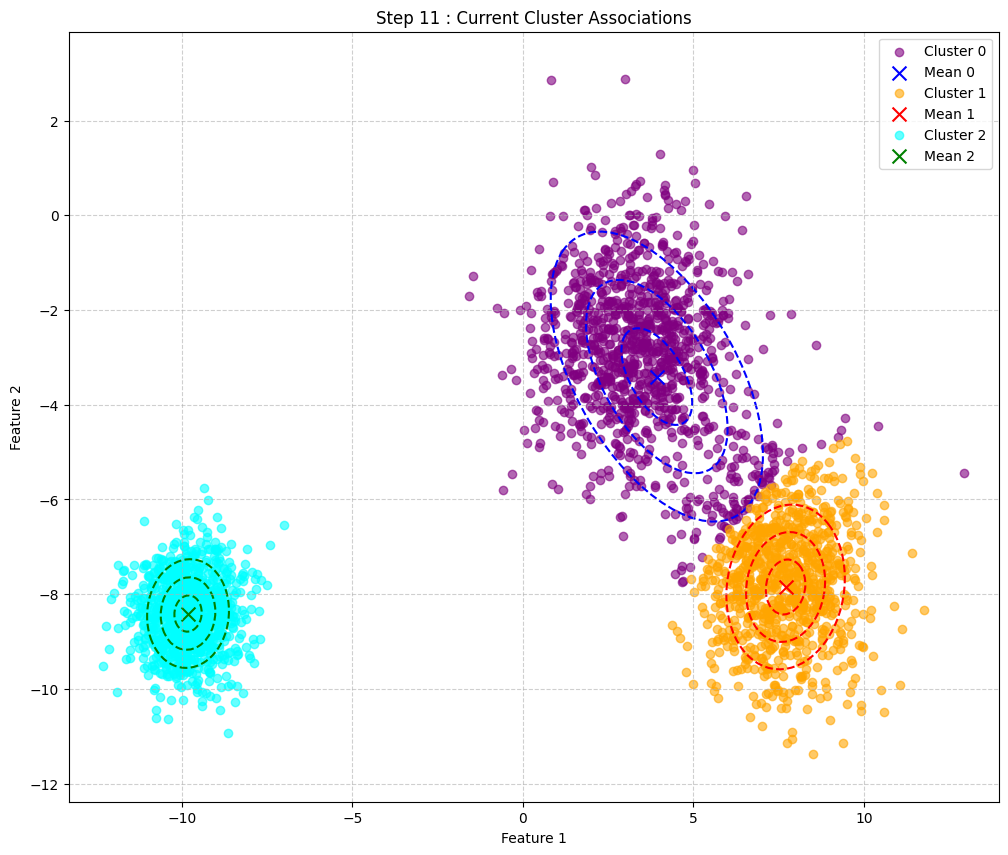

Log-Likelihood: -12614.503095771342
Mixing Coefficients: {0: np.float64(0.39178153028158236), 1: np.float64(0.27488513638568907), 2: np.float64(0.3333333333327287)} 

Means: {0: array([ 3.74975926, -3.23272208]), 1: array([ 7.70571979, -7.80147291]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 3.68920609, -1.68117425],
       [-1.68117425,  3.59551678]]), 1: array([[1.40245357, 0.12314759],
       [0.12314759, 1.41135154]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 13


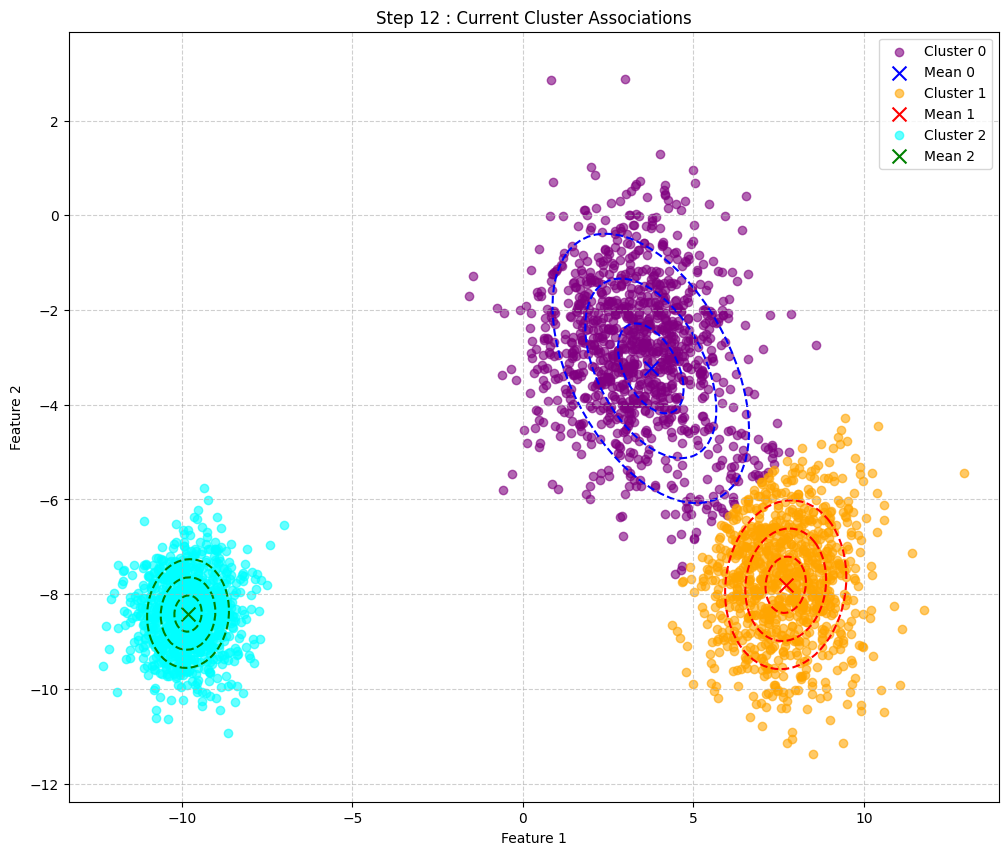

Log-Likelihood: -12564.287352457146
Mixing Coefficients: {0: np.float64(0.3741219955721955), 1: np.float64(0.2925446710949415), 2: np.float64(0.33333333333286297)} 

Means: {0: array([ 3.57634525, -3.06229755]), 1: array([ 7.68868846, -7.74362722]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 3.09487176, -1.11285868],
       [-1.11285868,  3.04704756]]), 1: array([[1.45186964, 0.11059922],
       [0.11059922, 1.47265342]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 14


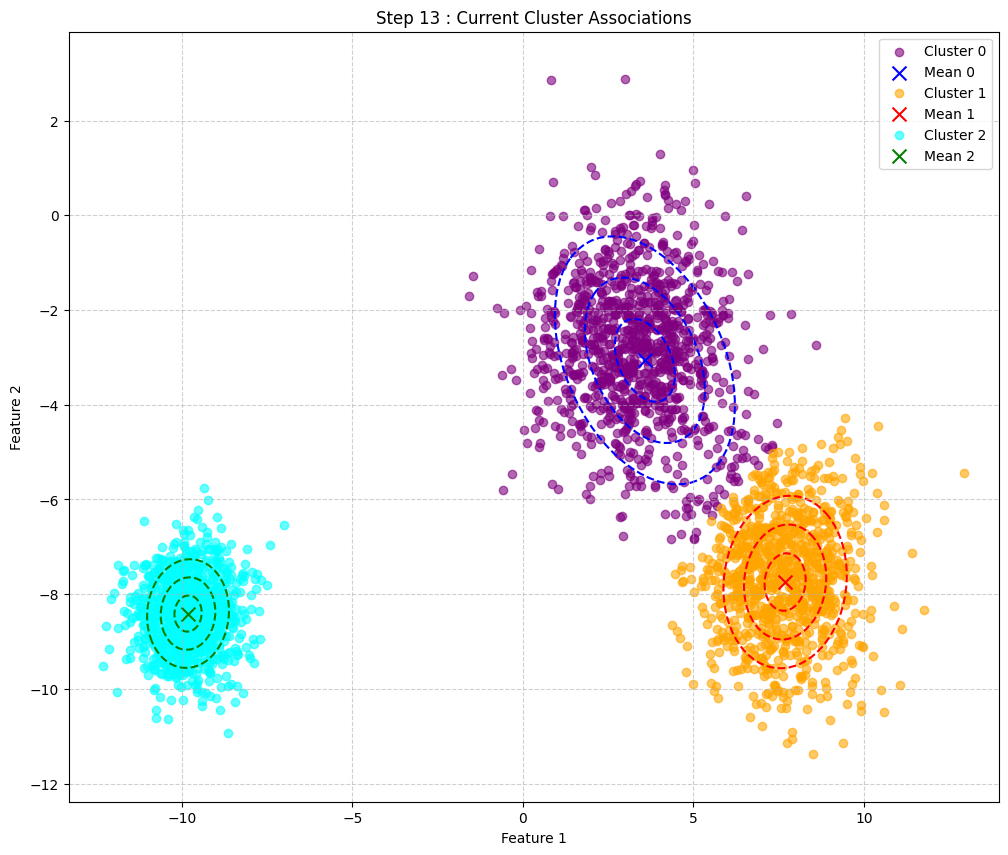

Log-Likelihood: -12518.52769775827
Mixing Coefficients: {0: np.float64(0.35884779523583815), 1: np.float64(0.3078188714311289), 2: np.float64(0.333333333333033)} 

Means: {0: array([ 3.42966212, -2.91462737]), 1: array([ 7.65563059, -7.68348649]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.6277819 , -0.64581539],
       [-0.64581539,  2.59012544]]), 1: array([[1.48447919, 0.08584861],
       [0.08584861, 1.53005261]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 15


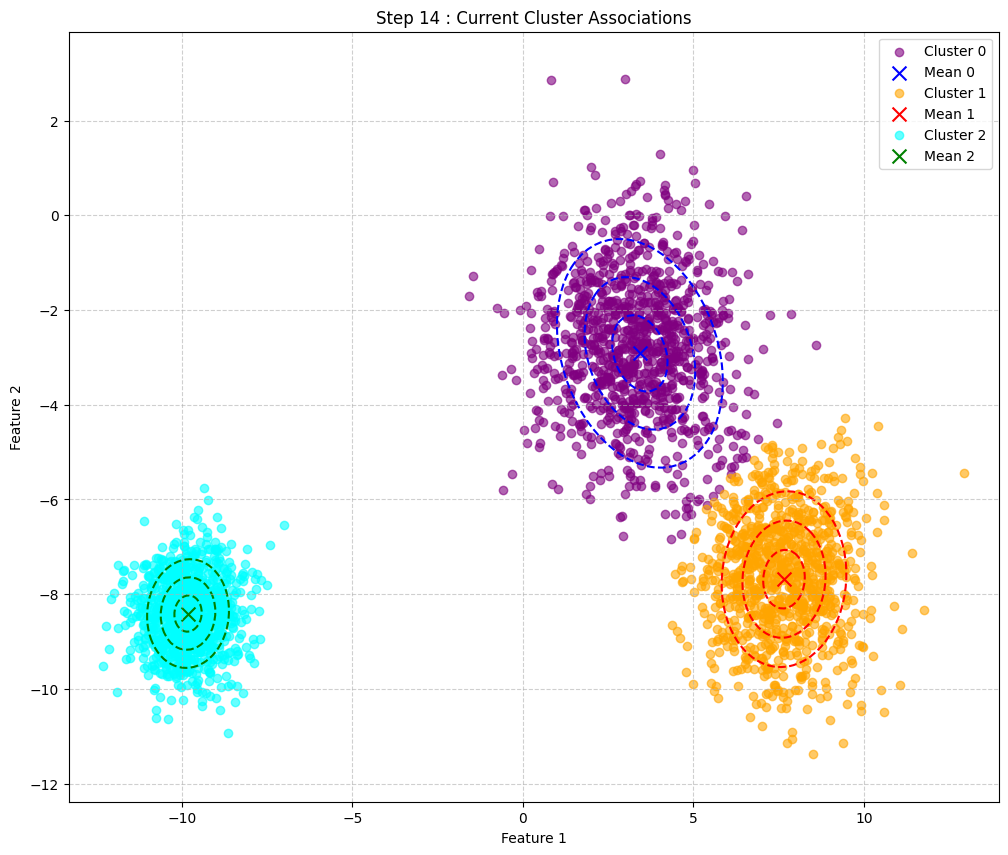

Log-Likelihood: -12489.508030361263
Mixing Coefficients: {0: np.float64(0.3476848493433007), 1: np.float64(0.31898181732356634), 2: np.float64(0.333333333333133)} 

Means: {0: array([ 3.32767965, -2.80795322]), 1: array([ 7.61889966, -7.63287066]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.33586558, -0.3295202 ],
       [-0.3295202 ,  2.27442641]]), 1: array([[1.51545665, 0.04540576],
       [0.04540576, 1.5831818 ]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 16


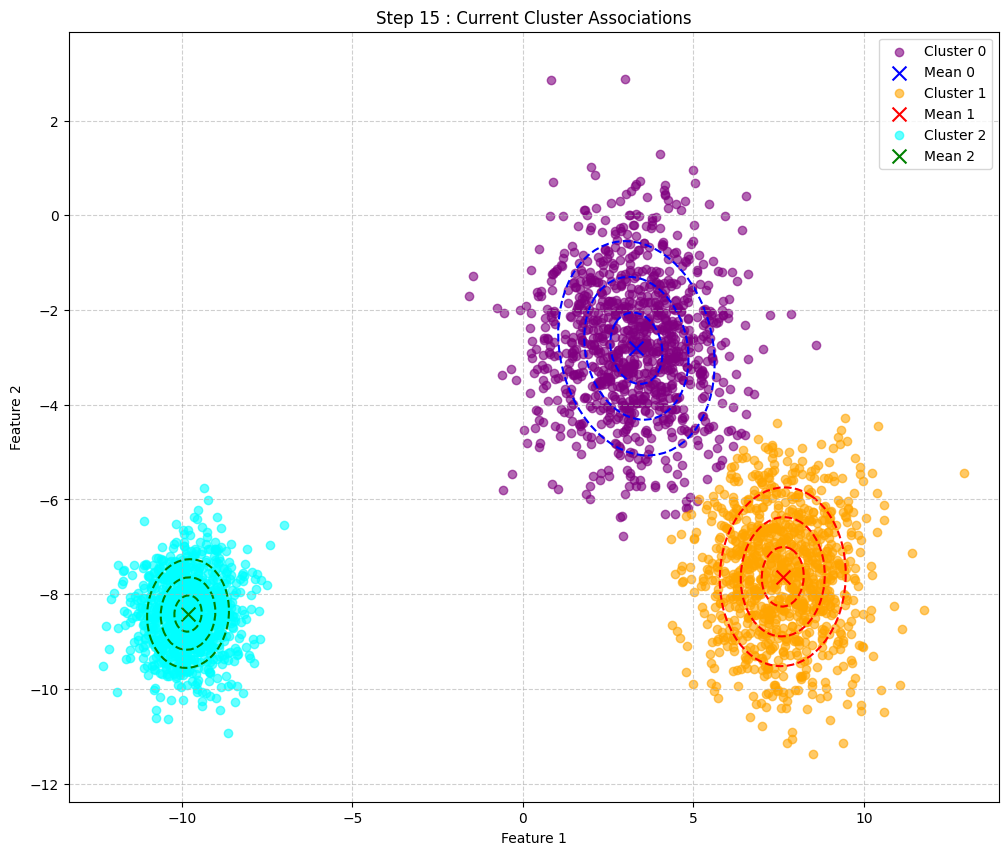

Log-Likelihood: -12477.533576672804
Mixing Coefficients: {0: np.float64(0.34080037849065775), 1: np.float64(0.32586628817616836), 2: np.float64(0.33333333333317383)} 

Means: {0: array([ 3.26929222, -2.74486594]), 1: array([ 7.58930372, -7.5969147 ]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.18878162, -0.15781115],
       [-0.15781115,  2.10075809]]), 1: array([[1.54713942, 0.00315325],
       [0.00315325, 1.62910133]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 17


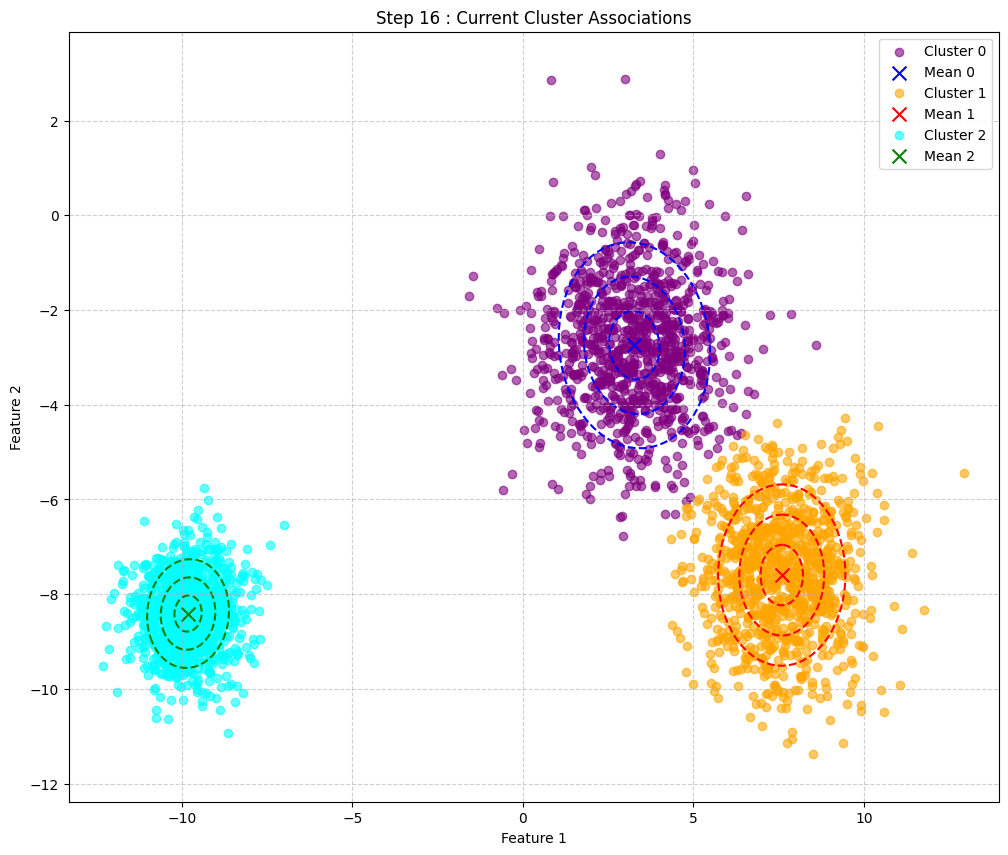

Log-Likelihood: -12473.970987636487
Mixing Coefficients: {0: np.float64(0.3370629344034947), 1: np.float64(0.32960373226331713), 2: np.float64(0.33333333333318815)} 

Means: {0: array([ 3.23984799, -2.71265161]), 1: array([ 7.5704288, -7.5748397]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.12280888, -0.0775377 ],
       [-0.0775377 ,  2.01948841]]), 1: array([[ 1.57209982, -0.02864168],
       [-0.02864168,  1.66327605]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 18


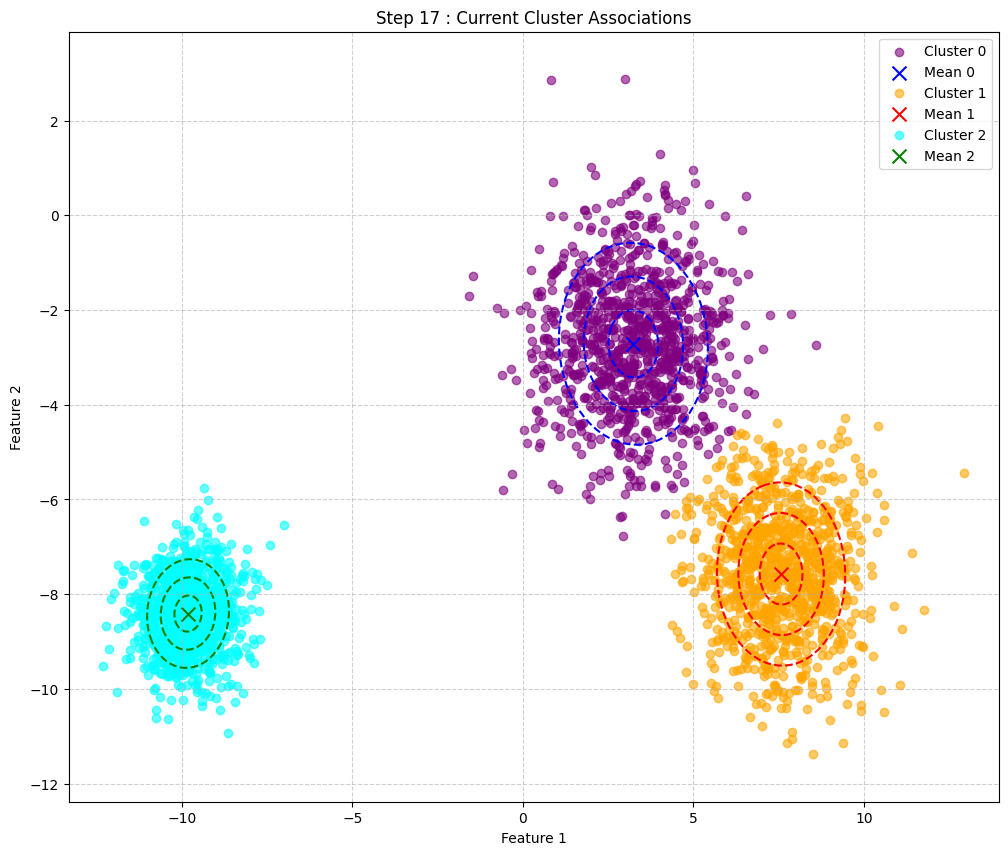

Log-Likelihood: -12473.068749219467
Mixing Coefficients: {0: np.float64(0.3351757255736894), 1: np.float64(0.3314909410931171), 2: np.float64(0.3333333333331935)} 

Means: {0: array([ 3.22572068, -2.69728477]), 1: array([ 7.56005875, -7.56269646]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.09342412, -0.04169101],
       [-0.04169101,  1.983523  ]]), 1: array([[ 1.58768598, -0.04795387],
       [-0.04795387,  1.68477867]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 19


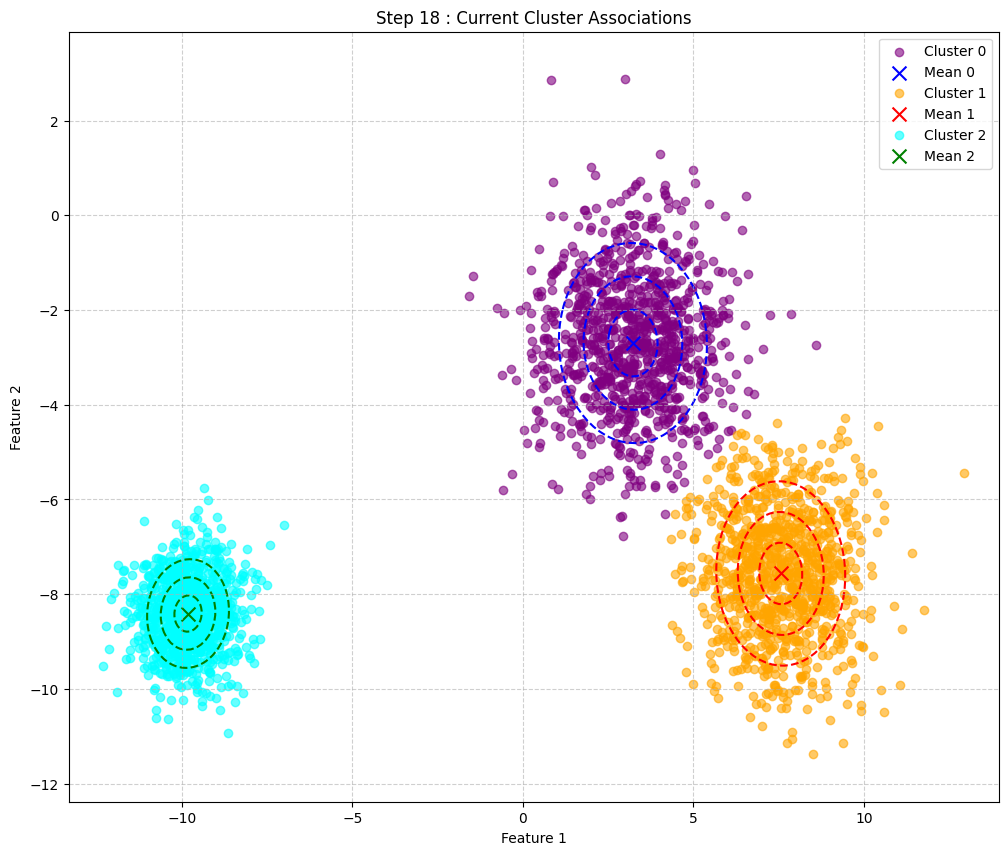

Log-Likelihood: -12472.853424371731
Mixing Coefficients: {0: np.float64(0.3342523309439469), 1: np.float64(0.33241433572285684), 2: np.float64(0.3333333333331963)} 

Means: {0: array([ 3.21900862, -2.69006112]), 1: array([ 7.55476782, -7.55644471]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.07998742, -0.0255063 ],
       [-0.0255063 ,  1.96746856]]), 1: array([[ 1.59620802, -0.05838853],
       [-0.05838853,  1.69673716]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 20


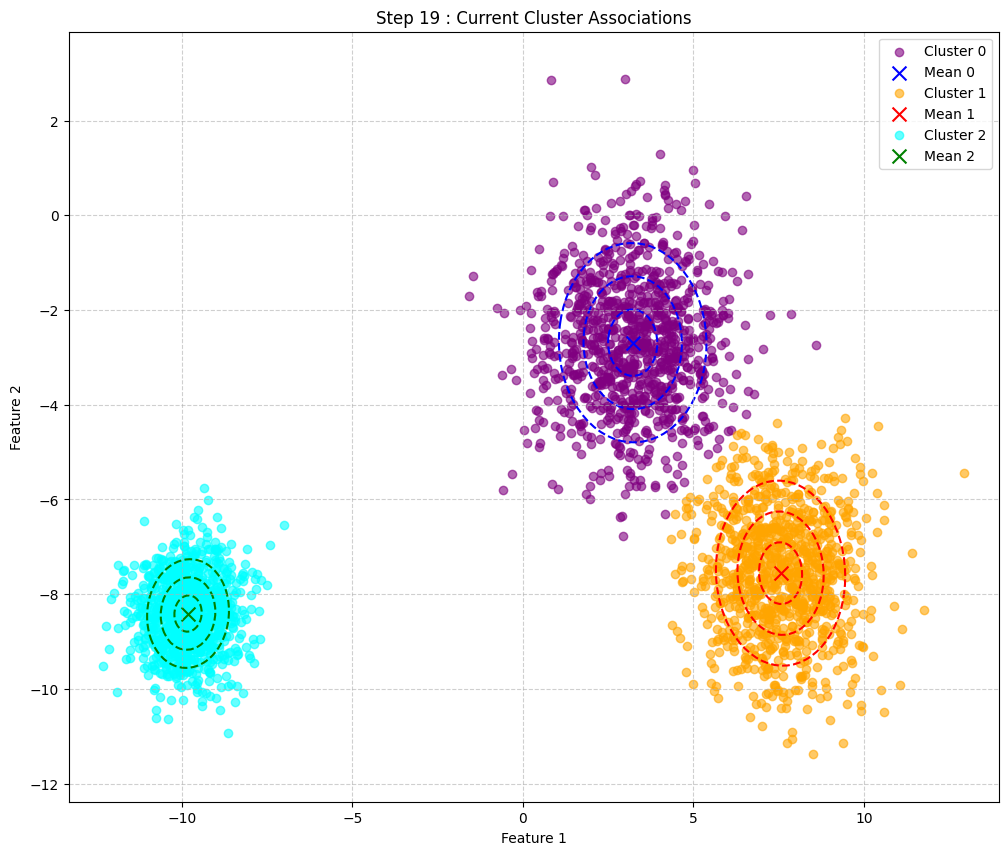

Log-Likelihood: -12472.803067786892
Mixing Coefficients: {0: np.float64(0.3338057003281195), 1: np.float64(0.3328609663386826), 2: np.float64(0.33333333333319787)} 

Means: {0: array([ 3.21581232, -2.68664871]), 1: array([ 7.55215549, -7.55333712]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.07370786, -0.01802824],
       [-0.01802824,  1.96011267]]), 1: array([[ 1.60056618, -0.06369985],
       [-0.06369985,  1.70292539]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 21


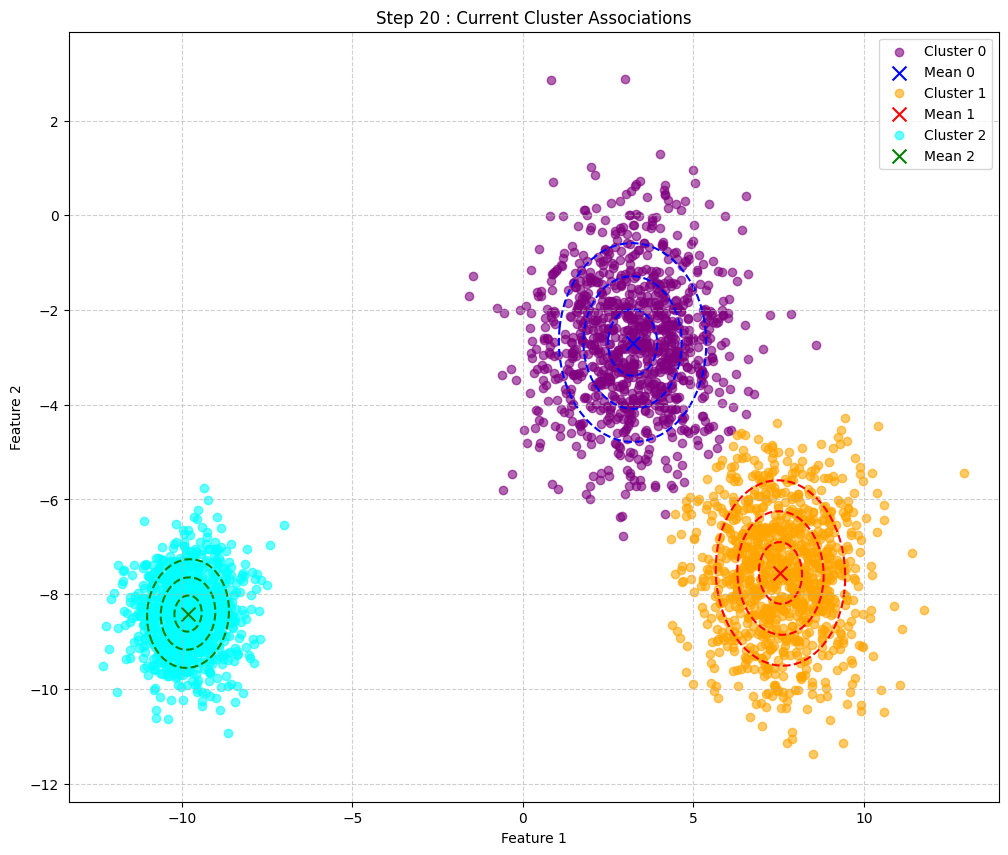

Log-Likelihood: -12472.791380217
Mixing Coefficients: {0: np.float64(0.33359056312573665), 1: np.float64(0.33307610354106465), 2: np.float64(0.33333333333319864)} 

Means: {0: array([ 3.21428481, -2.68502555]), 1: array([ 7.55088448, -7.55181934]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.0707342 , -0.01451159],
       [-0.01451159,  1.95667045]]), 1: array([[ 1.60272357, -0.06632418],
       [-0.06632418,  1.706009  ]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 22


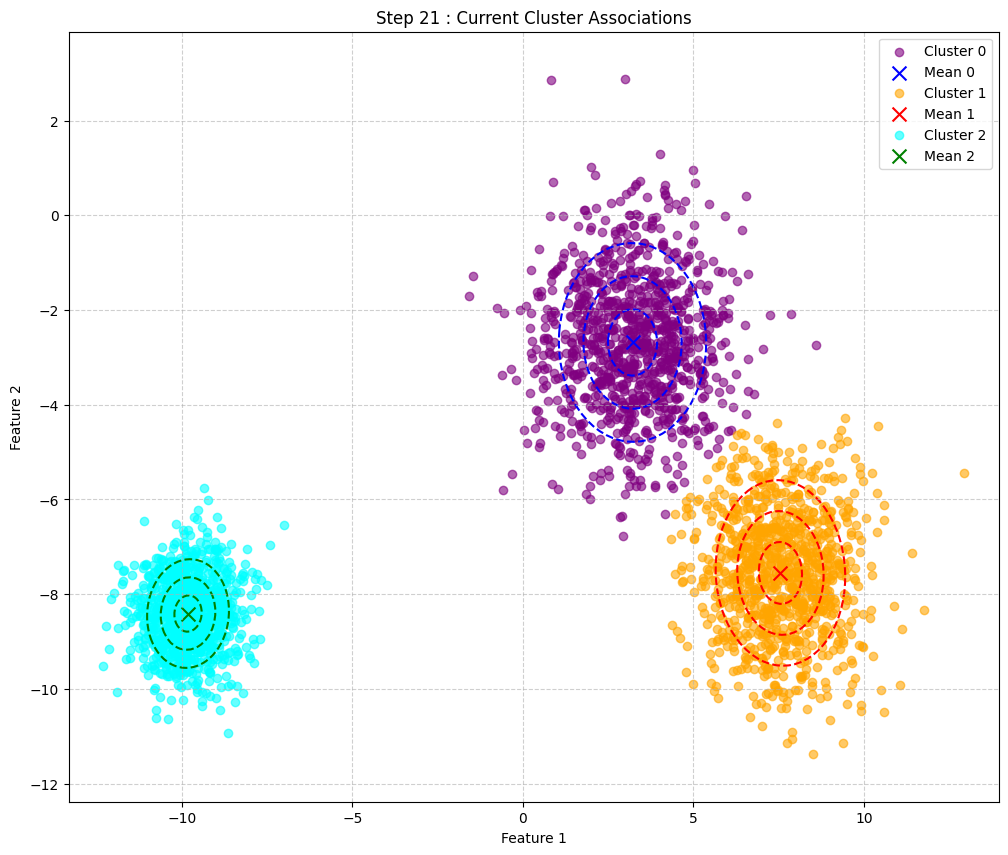

Log-Likelihood: -12472.788676173215
Mixing Coefficients: {0: np.float64(0.33348709737398297), 1: np.float64(0.333179569292818), 2: np.float64(0.3333333333331991)} 

Means: {0: array([ 3.21355304, -2.68424987]), 1: array([ 7.55027023, -7.5510844 ]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.06931597, -0.01284058],
       [-0.01284058,  1.95503906]]), 1: array([[ 1.60377495, -0.06760212],
       [-0.06760212,  1.70751687]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 23


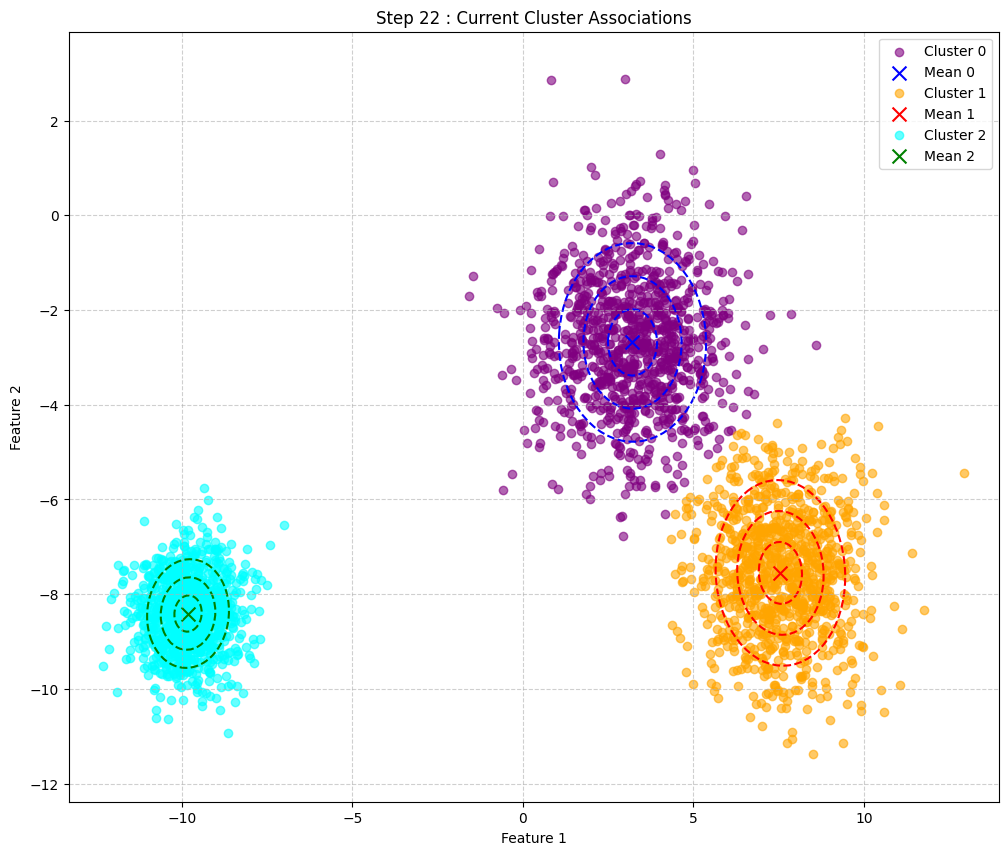

Log-Likelihood: -12472.788051454794
Mixing Coefficients: {0: np.float64(0.3334373702702414), 1: np.float64(0.33322929639655935), 2: np.float64(0.3333333333331993)} 

Means: {0: array([ 3.213202  , -2.68387824]), 1: array([ 7.54997433, -7.55073   ]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.06863709, -0.0120422 ],
       [-0.0120422 ,  1.95426063]]), 1: array([[ 1.60428349, -0.06822004],
       [-0.06822004,  1.70824745]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 24


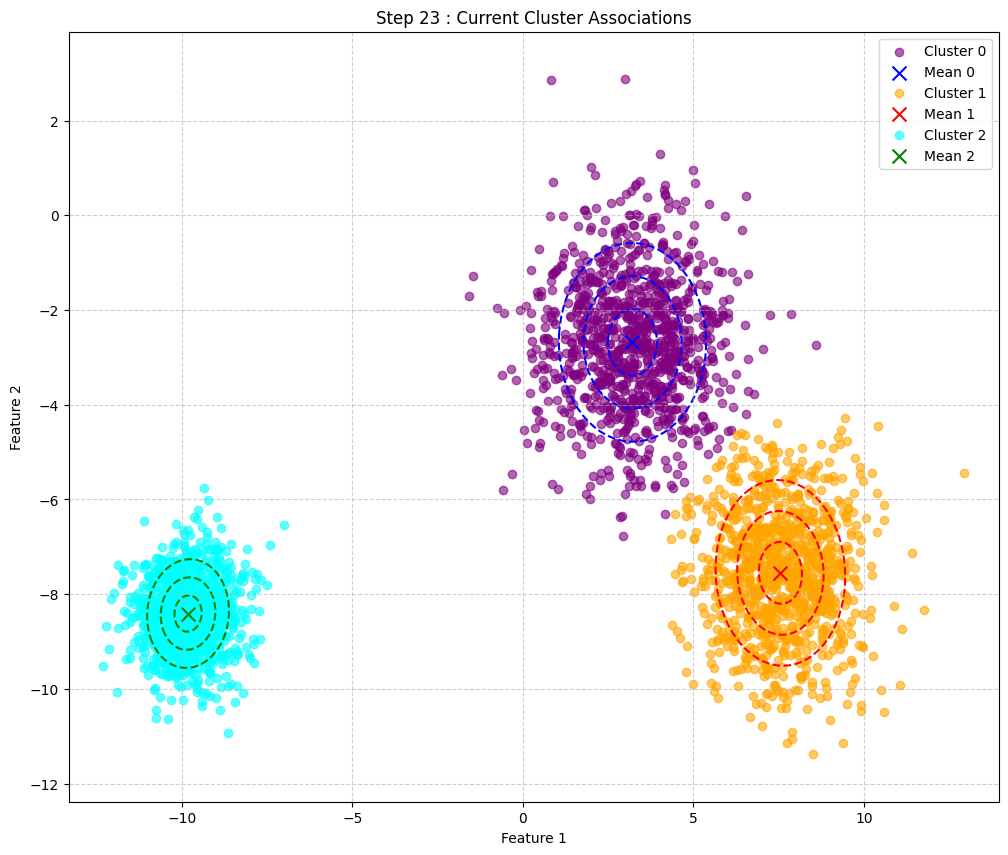

Log-Likelihood: -12472.787907221007
Mixing Coefficients: {0: np.float64(0.3334134776430592), 1: np.float64(0.33325318902374146), 2: np.float64(0.3333333333331994)} 

Means: {0: array([ 3.2130335 , -2.68369995]), 1: array([ 7.54983199, -7.55055945]), 2: array([-9.81788737, -8.4093266 ])} 

Covariances: {0: array([[ 2.06831155, -0.0116597 ],
       [-0.0116597 ,  1.95388793]]), 1: array([[ 1.60452859, -0.0685178 ],
       [-0.0685178 ,  1.70859984]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}

Step 25


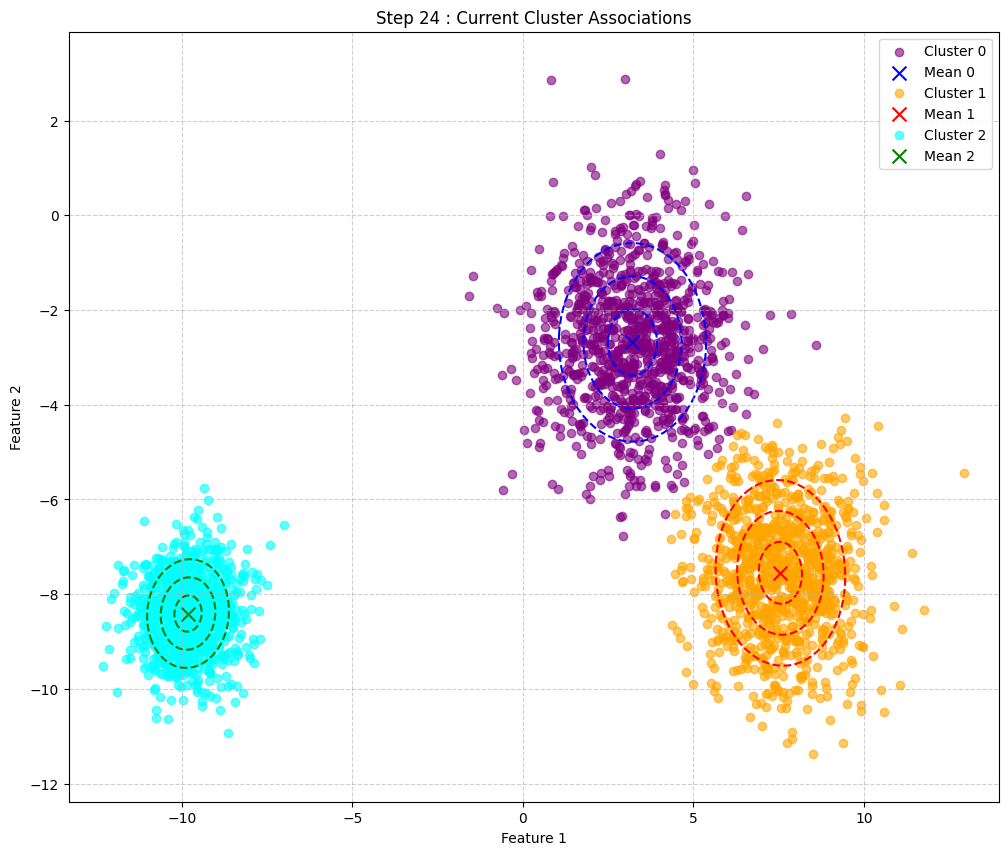

Log-Likelihood: -12472.787873931029
Convergence reached at step 25.

Final Parameters:
Mixing Coefficients: {0: np.float64(0.3334019993638585), 1: np.float64(0.333264667302942), 2: np.float64(0.3333333333331994)}
Means: {0: array([ 3.21295258, -2.68361436]), 1: array([ 7.54976357, -7.55047745]), 2: array([-9.81788737, -8.4093266 ])}
Covariances: {0: array([[ 2.0681553 , -0.0114762 ],
       [-0.0114762 ,  1.95370918]]), 1: array([[ 1.60464651, -0.06866105],
       [-0.06866105,  1.70876945]]), 2: array([[0.63994534, 0.03083351],
       [0.03083351, 0.585031  ]])}


<Figure size 640x480 with 0 Axes>

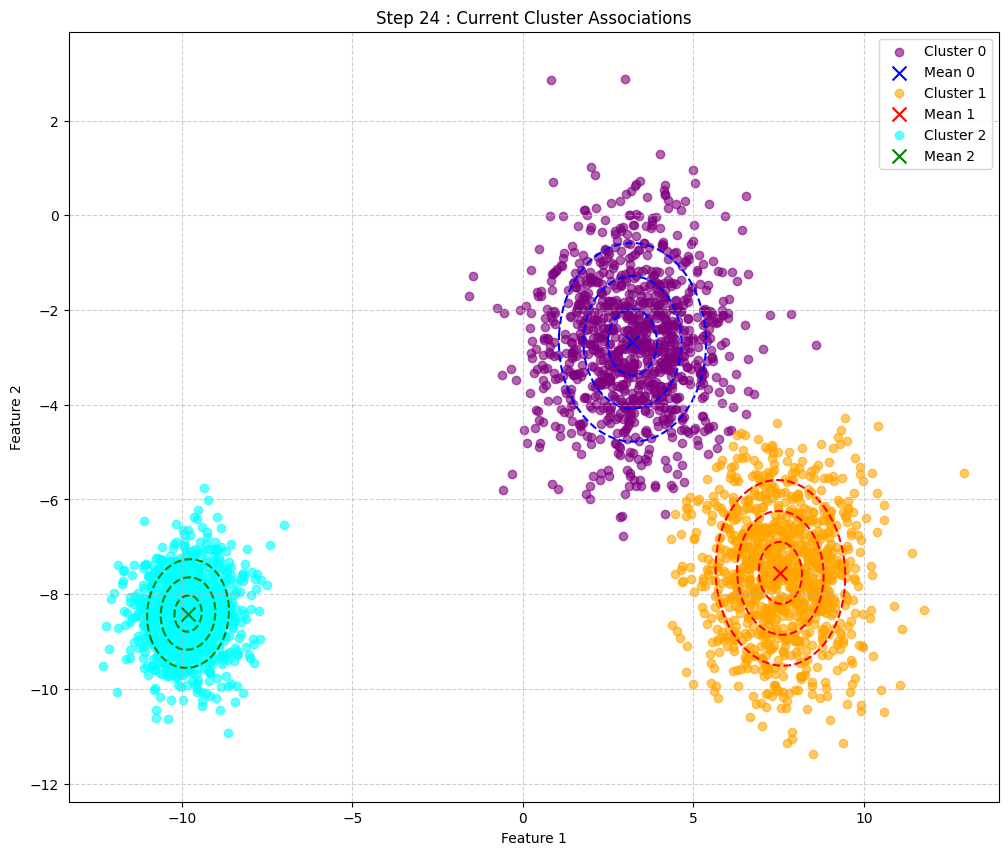

In [10]:
# Example usage
mixing_dic, mean_dic, cov_dic = train_gmm(X, n_components=k, n_steps=300, plot_intermediate_steps_flag=True)